Set the path to the `xls` file

In [3]:
training_file = "../TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [76]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))  # Adjust the path as needed

from my_util import df_to_corr_matrix, remove_outliers

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.impute import KNNImputer


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from joblib import Parallel, delayed

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

from pickle import dump , load

import warnings

In [6]:
NUM_OF_SELECTED_FEATURES = "regression_features_corr_25"

data = pd.read_excel(training_file)
data.replace(999, np.nan, inplace=True)

data.drop(["ID", "pCR (outcome)"], axis=1, inplace=True)
data.dropna(subset=["RelapseFreeSurvival (outcome)"], inplace=True)

with open(f'../FeatureSelection/pkl/{NUM_OF_SELECTED_FEATURES}_selected_features.pkl', mode='rb') as file:
    selected_features = load(file)
    print(f"Loaded '{file.name}' to selected_feature")

X = data[selected_features]
y = data["RelapseFreeSurvival (outcome)"]
print(X.shape, y.shape)

print(selected_features)

Loaded '../FeatureSelection/pkl/regression_features_corr_25_selected_features.pkl' to selected_feature
(400, 25) (400,)
['original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'TumourStage', 'original_shape_MajorAxisLength', 'original_firstorder_90Percentile', 'ChemoGrade', 'HER2', 'original_shape_Maximum2DDiameterRow', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_glszm_SmallAreaEmphasis', 'Age', 'original_shape_Sphericity', 'original_firstorder_10Percentile', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_gldm_DependenceEntropy', 'original_ngtdm_Busyness', 'original_glcm_Imc1', 'Gene', 'original_gldm_SmallDependenceEmphasis', 'original_glszm_GrayLevelNonUniformityNormalized', 'PgR', 'TrippleNegative', 'original_shape_Elongation', 'original_glcm_Correlation']


In [61]:
import random

randomstate = random.randint(0, 1000)
randomstate = 7
X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=randomstate) # similar distribution of 1 and 0

X_train_full.reset_index(drop=True, inplace=True)
X_test_reserved.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)
y_test_reserved.reset_index(drop=True, inplace=True)


print("Splited the data into train and test. The test will not be used in the training, but just for test the xgb. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"RandomState = {randomstate}")


Splited the data into train and test. The test will not be used in the training, but just for test the xgb. 
The training data has 320 data. The testing data has 80 data. 
RandomState = 7


(array([0.00499132, 0.00434028, 0.01540799, 0.01236979, 0.01388889,
        0.00976562, 0.00499132, 0.0015191 , 0.00065104, 0.0015191 ]),
 array([  0. ,  14.4,  28.8,  43.2,  57.6,  72. ,  86.4, 100.8, 115.2,
        129.6, 144. ]),
 <BarContainer object of 10 artists>)

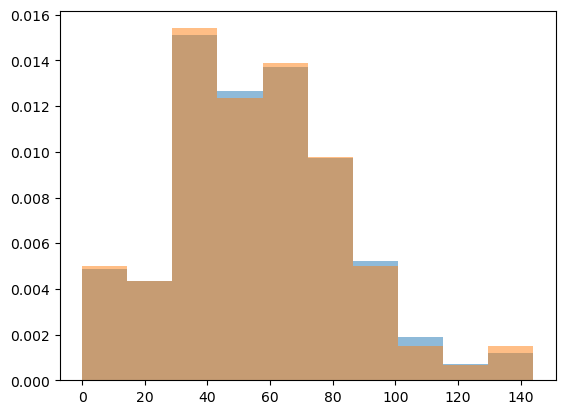

In [62]:
plt.hist(y, density=True, alpha=0.5)
plt.hist(y_train_full, density=True, alpha=0.5)

In [103]:
model = XGBRegressor(objective="reg:absoluteerror")

param_grid = {
    "gamma": [0, 0.1, 0.2],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "max_bin": [2, 3, 4, 5, 10],
    "max_delta_step": [0, 1, 2],
    "max_depth": [1, 2, 4, 6],
    "max_leaves": [0, 1, 2, 3, 4, 5],
    "min_child_weight": [0.001, 0.01, 0.1, 0.5],
    "n_estimators": [10, 50, 100, 200],
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', 
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
)

grid_search.fit(X_train_full, y_train_full)

print(f"Best parameter: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 69120 candidates, totalling 345600 fits
Best parameter: {'gamma': 0, 'learning_rate': 0.1, 'max_bin': 3, 'max_delta_step': 0, 'max_depth': 2, 'max_leaves': 3, 'min_child_weight': 0.001, 'n_estimators': 100}
Best score: -20.039419563611347


In [104]:
pd.DataFrame(grid_search.cv_results_).to_csv("output.csv")

In [109]:
print(grid_search.best_params_)
print(grid_search.best_score_)

model = grid_search.best_estimator_

y_pred = model.predict(X_test_reserved)

print(mean_absolute_error(y_test_reserved, y_pred))

l1 = np.array(list(y_test_reserved))
l2 = np.array(list(y_pred))
l3 = l1 - l2

display(pd.DataFrame([l1, l2, l3]).T)

{'gamma': 0, 'learning_rate': 0.1, 'max_bin': 3, 'max_delta_step': 0, 'max_depth': 2, 'max_leaves': 3, 'min_child_weight': 0.001, 'n_estimators': 100}
-20.039419563611347
20.508699798583983


,0,1,2
0,43.000000,37.987656,5.012344
1,9.000000,53.990318,-44.990318
2,73.000000,59.660213,13.339787
3,16.000000,53.314426,-37.314426
4,59.000000,60.072800,-1.072800
...,...,...,...
75,53.000000,55.507435,-2.507435
76,93.000000,59.416786,33.583214
77,82.416667,47.146587,35.270079
78,89.000000,57.640259,31.359741
